In [ ]:
# [CLS]トークンを利用

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='014'
    debug=False  # False
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Tue Jun  7 05:07:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 4.1 MB/s 
CPU times: user 1.05 s, sys: 224 ms, total: 1.27 s
Wall time: 20.5 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        anonymous=anony)

     |████████████████████████████████| 1.8 MB 6.9 MB/s 
     |████████████████████████████████| 181 kB 55.7 MB/s 
     |████████████████████████████████| 145 kB 53.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['anchor_context'] = train['anchor'] + '.' + ' [s] ' + train['context_text'] + '.'
test['anchor_context'] = test['anchor'] + '.' + ' [s] ' + test['context_text'] + '.'
train['target_context'] = train['target'] + '.' + ' [s] ' + train['context_text'] + '.'
test['target_context'] = test['target'] + '.' + ' [s] ' + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,anchor_context,target_context
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [s] HUMAN NECESSITIES. FURNITURE. D...,abatement of pollution. [s] HUMAN NECESSITIES....
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [s] HUMAN NECESSITIES. FURNITURE. D...,act of abating. [s] HUMAN NECESSITIES. FURNITU...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [s] HUMAN NECESSITIES. FURNITURE. D...,active catalyst. [s] HUMAN NECESSITIES. FURNIT...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [s] HUMAN NECESSITIES. FURNITURE. D...,eliminating process. [s] HUMAN NECESSITIES. FU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [s] HUMAN NECESSITIES. FURNITURE. D...,forest region. [s] HUMAN NECESSITIES. FURNITUR...


,id,anchor,target,context,context_text,anchor_context,target_context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [s] PHYSICS. OPTICS.,inorganic photoconductor drum. [s] PHYSICS. OP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [s] MECHANICAL ENGINEERING. L...,altering gas flow. [s] MECHANICAL ENGINEERING....
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [s] PERFORMING OPERATIONS. TRA...,lower locating. [s] PERFORMING OPERATIONS. TRA...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [s] TEXTILES. PAPER. TREATMENT ...,upper portion. [s] TEXTILES. PAPER. TREATMENT ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [s] ELECTRICITY. ELECTRIC ...,artificial neural network. [s] ELECTRICITY. EL...


# EDA

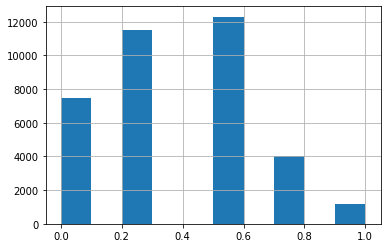

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
# lengths_dict = {}

# lengths = []
# tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
# for text in tk0:
#     length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#     lengths.append(length)
# lengths_dict['context_text'] = lengths

# for text_col in ['anchor', 'target']:
#     lengths = []
#     tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
#     for text in tk0:
#         length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
#         lengths.append(length)
#     lengths_dict[text_col] = lengths
    
CFG.max_len = train.progress_apply(lambda row: len(CFG.tokenizer(row['anchor_context'], 
                                                                 row['target_context'], 
                                                                 add_special_tokens=True)['input_ids']), 
                                   axis=1).max()
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 141


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, anchor, target):
    inputs = cfg.tokenizer(anchor, target,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.anchors = df['anchor_context'].values
        self.targets = df['target_context'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.anchors[item], self.targets[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
train_dataset = TrainDataset(CFG, train, 'train')
inputs, label = train_dataset[0]
print(inputs)
print(label)

{'input_ids': tensor([    1, 47284,   260,   647,   268,   592,   857, 19629,   260,  2075,
          260,  3090,  2502,   289,  6328,   260,  1818, 13498,   260, 10224,
        13498,   260, 22157, 13952,   267,  1042,   260,     2, 47284,   265,
         6435,   260,   647,   268,   592,   857, 19629,   260,  2075,   260,
         3090,  2502,   289,  6328,   260,  1818, 13498,   260, 10224, 13498,
          260, 22157, 13952,   267,  1042,   260,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 40m 37s) Loss: 0.6992(0.6992) Grad: 221982.2344  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 41s (remain 26m 45s) Loss: 0.5472(0.6317) Grad: 58665.6367  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 3m 22s (remain 25m 3s) Loss: 0.6320(0.6182) Grad: 74835.6016  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 5m 2s (remain 23m 20s) Loss: 0.5536(0.6048) Grad: 27720.2383  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 6m 43s (remain 21m 38s) Loss: 0.6425(0.5969) Grad: 56836.8047  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 8m 23s (remain 19m 57s) Loss: 0.4016(0.5881) Grad: 41088.1836  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 10m 3s (remain 18m 16s) Loss: 0.6590(0.5825) Grad: 30884.3984  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 11m 43s (remain 16m 35s) Loss: 0.5854(0.5802) Grad: 23570.8848  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 13m 23s (remain 14m 54s) Loss: 0.5866(0.5787) Grad: 11773.2061  LR: 0.00001932  
Epoch: [1][900/1693] 

Epoch 1 - avg_train_loss: 0.5633  avg_val_loss: 0.5524  time: 1875s
Epoch 1 - Score: 0.8178


EVAL: [586/587] Elapsed 2m 58s (remain 0m 0s) Loss: 0.6820(0.5524) 


Epoch 1 - Save Best Score: 0.8178 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 48m 1s) Loss: 0.5750(0.5750) Grad: 109027.2812  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 43s (remain 27m 11s) Loss: 0.6807(0.5223) Grad: 60802.4492  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 3m 23s (remain 25m 11s) Loss: 0.4302(0.5234) Grad: 20726.7461  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 5m 3s (remain 23m 25s) Loss: 0.5355(0.5195) Grad: 18736.1543  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 6m 43s (remain 21m 41s) Loss: 0.5413(0.5194) Grad: 49474.0898  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 8m 24s (remain 19m 59s) Loss: 0.5775(0.5187) Grad: 23335.7305  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 10m 4s (remain 18m 17s) Loss: 0.4757(0.5201) Grad: 19738.2559  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 11m 44s (remain 16m 36s) Loss: 0.6647(0.5187) Grad: 40756.6523  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 13m 24s (remain 14m 55s) Loss: 0.6562(0.5200) Grad: 46273.2969  LR: 0.00001402  
Epoch: [2][900/1693] 

Epoch 2 - avg_train_loss: 0.5193  avg_val_loss: 0.5439  time: 1876s
Epoch 2 - Score: 0.8367


EVAL: [586/587] Elapsed 2m 57s (remain 0m 0s) Loss: 0.6733(0.5439) 


Epoch 2 - Save Best Score: 0.8367 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 37m 13s) Loss: 0.5568(0.5568) Grad: 124926.0391  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 42s (remain 27m 0s) Loss: 0.4038(0.4982) Grad: 40500.5586  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 3m 22s (remain 25m 5s) Loss: 0.5180(0.4974) Grad: 42662.7773  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 5m 2s (remain 23m 20s) Loss: 0.5233(0.4980) Grad: 17034.0000  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 6m 42s (remain 21m 37s) Loss: 0.5172(0.4990) Grad: 22614.0254  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 8m 22s (remain 19m 56s) Loss: 0.5309(0.4981) Grad: 43221.0234  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 10m 2s (remain 18m 15s) Loss: 0.5027(0.4994) Grad: 32791.2656  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 11m 42s (remain 16m 34s) Loss: 0.4665(0.4998) Grad: 42352.0273  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 13m 23s (remain 14m 54s) Loss: 0.4720(0.5023) Grad: 18172.2129  LR: 0.00000637  
Epoch: [3][900/1693] E

Epoch 3 - avg_train_loss: 0.5023  avg_val_loss: 0.5517  time: 1874s
Epoch 3 - Score: 0.8366


EVAL: [586/587] Elapsed 2m 58s (remain 0m 0s) Loss: 0.6747(0.5517) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 38m 22s) Loss: 0.4034(0.4034) Grad: 37725.5977  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 42s (remain 26m 54s) Loss: 0.4160(0.5048) Grad: 17731.4238  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 3m 22s (remain 25m 5s) Loss: 0.5104(0.4999) Grad: 35017.8398  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 5m 3s (remain 23m 22s) Loss: 0.5470(0.4988) Grad: 20097.4082  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 6m 43s (remain 21m 40s) Loss: 0.5164(0.4967) Grad: 23338.1816  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 8m 24s (remain 19m 59s) Loss: 0.5959(0.4973) Grad: 31573.3535  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 10m 4s (remain 18m 18s) Loss: 0.6380(0.4972) Grad: 16284.6201  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 11m 44s (remain 16m 37s) Loss: 0.4456(0.4958) Grad: 27754.2695  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 13m 25s (remain 14m 56s) Loss: 0.39

Epoch 4 - avg_train_loss: 0.4956  avg_val_loss: 0.5620  time: 1877s
Epoch 4 - Score: 0.8342


EVAL: [586/587] Elapsed 2m 58s (remain 0m 0s) Loss: 0.6773(0.5620) 


========== fold: 0 result ==========
Score: 0.8367
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 42m 24s) Loss: 0.7058(0.7058) Grad: 272015.5938  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 42s (remain 27m 25s) Loss: 0.6686(0.6315) Grad: 54947.4648  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 3m 22s (remain 25m 35s) Loss: 0.5891(0.6146) Grad: 36698.4609  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 5m 2s (remain 23m 51s) Loss: 0.6500(0.6019) Grad: 33659.8516  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 6m 42s (remain 22m 9s) Loss: 0.6178(0.5935) Grad: 29089.9707  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 8m 22s (remain 20m 28s) Loss: 0.5250(0.5875) Grad: 28658.3984  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 10m 2s (remain 18m 47s) Loss: 0.5387(0.5834) Grad: 24315.4355  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 11m 43s (remain 17m 7s) Loss: 0.5214(0.5807) Grad: 22909.5918  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 13m 23s (remain 15m 26s) Loss: 0.4712(0.5760) Grad: 26569.6699  LR: 0.00001934  
Epoch: [1][900/1725] E

Epoch 1 - avg_train_loss: 0.5624  avg_val_loss: 0.5558  time: 1897s
Epoch 1 - Score: 0.8085


EVAL: [553/554] Elapsed 2m 48s (remain 0m 0s) Loss: 0.5004(0.5558) 


Epoch 1 - Save Best Score: 0.8085 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 45m 13s) Loss: 0.4753(0.4753) Grad: 88065.2031  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 43s (remain 27m 38s) Loss: 0.5951(0.5324) Grad: 84952.0078  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 3m 23s (remain 25m 41s) Loss: 0.4869(0.5297) Grad: 107750.0625  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 5m 3s (remain 23m 56s) Loss: 0.5594(0.5290) Grad: 114677.5703  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 6m 43s (remain 22m 12s) Loss: 0.4925(0.5249) Grad: 60527.4727  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 8m 23s (remain 20m 30s) Loss: 0.6346(0.5231) Grad: 373345.5000  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 10m 3s (remain 18m 49s) Loss: 0.3777(0.5226) Grad: 117492.6562  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 11m 44s (remain 17m 8s) Loss: 0.5771(0.5200) Grad: 94170.7109  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 13m 24s (remain 15m 27s) Loss: 0.6601(0.5200) Grad: 192456.1250  LR: 0.00001409  
Epoch: [2][900/17

Epoch 2 - avg_train_loss: 0.5185  avg_val_loss: 0.5585  time: 1899s
Epoch 2 - Score: 0.8222


EVAL: [553/554] Elapsed 2m 48s (remain 0m 0s) Loss: 0.5053(0.5585) 


Epoch 2 - Save Best Score: 0.8222 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 39m 51s) Loss: 0.5723(0.5723) Grad: 336535.0625  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 43s (remain 27m 43s) Loss: 0.4334(0.5127) Grad: 134014.1562  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 3m 24s (remain 25m 47s) Loss: 0.4627(0.5148) Grad: 65374.1406  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 5m 4s (remain 24m 0s) Loss: 0.4856(0.5158) Grad: 74110.0859  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 6m 44s (remain 22m 16s) Loss: 0.4618(0.5173) Grad: 79956.3672  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 8m 24s (remain 20m 33s) Loss: 0.5587(0.5142) Grad: 45235.8750  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 10m 5s (remain 18m 51s) Loss: 0.4984(0.5116) Grad: 85583.0000  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 11m 45s (remain 17m 10s) Loss: 0.5267(0.5118) Grad: 80652.6406  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 13m 25s (remain 15m 29s) Loss: 0.5106(0.5106) Grad: 77835.4141  LR: 0.00000644  
Epoch: [3][900/1725]

Epoch 3 - avg_train_loss: 0.5070  avg_val_loss: 0.5659  time: 1899s
Epoch 3 - Score: 0.8236


EVAL: [553/554] Elapsed 2m 48s (remain 0m 0s) Loss: 0.4979(0.5659) 


Epoch 3 - Save Best Score: 0.8236 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 41m 2s) Loss: 0.4617(0.4617) Grad: 38143.6680  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 43s (remain 27m 38s) Loss: 0.5880(0.5026) Grad: 100243.7891  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 3m 23s (remain 25m 41s) Loss: 0.3006(0.5039) Grad: 63657.5352  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 5m 3s (remain 23m 55s) Loss: 0.5702(0.5043) Grad: 52385.6680  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 6m 43s (remain 22m 13s) Loss: 0.4168(0.5034) Grad: 34874.7500  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 8m 24s (remain 20m 31s) Loss: 0.4998(0.5042) Grad: 61530.5859  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 10m 4s (remain 18m 50s) Loss: 0.4986(0.5040) Grad: 72948.8906  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 11m 44s (remain 17m 9s) Loss: 0.4548(0.5032) Grad: 87742.6250  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 13m 25s (remain 15m 28s) Loss: 0.4947(0.5036) Grad: 128547.3828  LR: 0.00000088  
Epoch: [4][900/1725] 

Epoch 4 - avg_train_loss: 0.4999  avg_val_loss: 0.5667  time: 1900s
Epoch 4 - Score: 0.8244


EVAL: [553/554] Elapsed 2m 47s (remain 0m 0s) Loss: 0.4953(0.5667) 


Epoch 4 - Save Best Score: 0.8244 Model
========== fold: 1 result ==========
Score: 0.8244
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1741] Elapsed 0m 1s (remain 47m 0s) Loss: 0.6975(0.6975) Grad: 174975.1875  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 42s (remain 27m 48s) Loss: 0.6981(0.6650) Grad: 80562.8672  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 3m 22s (remain 25m 54s) Loss: 0.5895(0.6301) Grad: 121076.1172  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 5m 2s (remain 24m 9s) Loss: 0.5939(0.6149) Grad: 81314.1250  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 6m 43s (remain 22m 26s) Loss: 0.6382(0.6058) Grad: 113914.3594  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 8m 23s (remain 20m 45s) Loss: 0.6128(0.6008) Grad: 94164.0625  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 10m 3s (remain 19m 4s) Loss: 0.6199(0.5943) Grad: 73007.7344  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 11m 43s (remain 17m 23s) Loss: 0.6268(0.5884) Grad: 70771.0859  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 13m 23s (remain 15m 43s) Loss: 0.4551(0.5838) Grad: 58134.5625  LR: 0.00001935  
Epoch: [1][900/1741] 

Epoch 1 - avg_train_loss: 0.5686  avg_val_loss: 0.5522  time: 1909s
Epoch 1 - Score: 0.8123


EVAL: [538/539] Elapsed 2m 43s (remain 0m 0s) Loss: 0.3454(0.5522) 


Epoch 1 - Save Best Score: 0.8123 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 46m 25s) Loss: 0.3958(0.3958) Grad: 111419.0938  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 43s (remain 27m 56s) Loss: 0.5104(0.5338) Grad: 100099.8750  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 3m 23s (remain 25m 58s) Loss: 0.5602(0.5260) Grad: 197500.2188  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 5m 3s (remain 24m 12s) Loss: 0.5095(0.5254) Grad: 152397.0156  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 6m 43s (remain 22m 28s) Loss: 0.4015(0.5228) Grad: 183763.0000  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 8m 23s (remain 20m 46s) Loss: 0.4765(0.5226) Grad: 50746.7539  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 10m 4s (remain 19m 5s) Loss: 0.6183(0.5207) Grad: 76507.0703  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 11m 44s (remain 17m 25s) Loss: 0.5173(0.5216) Grad: 98728.9375  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 13m 24s (remain 15m 44s) Loss: 0.5511(0.5220) Grad: 112595.4922  LR: 0.00001412  
Epoch: [2][900/1

Epoch 2 - avg_train_loss: 0.5256  avg_val_loss: 0.5347  time: 1909s
Epoch 2 - Score: 0.8425


EVAL: [538/539] Elapsed 2m 43s (remain 0m 0s) Loss: 0.3466(0.5347) 


Epoch 2 - Save Best Score: 0.8425 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 46m 16s) Loss: 0.6035(0.6035) Grad: 276174.7188  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 43s (remain 27m 58s) Loss: 0.4930(0.5053) Grad: 57192.4297  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 3m 23s (remain 25m 58s) Loss: 0.5427(0.5096) Grad: 192911.7188  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 5m 3s (remain 24m 12s) Loss: 0.5062(0.5057) Grad: 108597.2344  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 6m 43s (remain 22m 29s) Loss: 0.5183(0.5050) Grad: 242246.4062  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 8m 23s (remain 20m 46s) Loss: 0.4762(0.5061) Grad: 45366.1328  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 10m 3s (remain 19m 5s) Loss: 0.6044(0.5077) Grad: 72408.1719  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 11m 44s (remain 17m 24s) Loss: 0.6453(0.5075) Grad: 66241.0938  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 13m 24s (remain 15m 43s) Loss: 0.6115(0.5093) Grad: 41999.3672  LR: 0.00000647  
Epoch: [3][900/174

Epoch 3 - avg_train_loss: 0.5126  avg_val_loss: 0.5419  time: 1910s
Epoch 3 - Score: 0.8409


EVAL: [538/539] Elapsed 2m 43s (remain 0m 0s) Loss: 0.3463(0.5419) 
Epoch: [4][0/1741] Elapsed 0m 1s (remain 38m 49s) Loss: 0.4397(0.4397) Grad: 100931.5391  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 42s (remain 27m 47s) Loss: 0.5242(0.5010) Grad: 91702.2266  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 3m 22s (remain 25m 53s) Loss: 0.5436(0.5037) Grad: 62258.4688  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 5m 2s (remain 24m 9s) Loss: 0.5279(0.5035) Grad: 31731.8750  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 6m 43s (remain 22m 27s) Loss: 0.5826(0.5045) Grad: 126846.3984  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 8m 23s (remain 20m 45s) Loss: 0.4891(0.5042) Grad: 102502.5469  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 10m 3s (remain 19m 4s) Loss: 0.4546(0.5036) Grad: 94894.3281  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 11m 43s (remain 17m 23s) Loss: 0.4565(0.5041) Grad: 37341.5312  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 13m 23s (remain 15m 43s) Loss: 0.

Epoch 4 - avg_train_loss: 0.5059  avg_val_loss: 0.5463  time: 1908s
Epoch 4 - Score: 0.8399


EVAL: [538/539] Elapsed 2m 43s (remain 0m 0s) Loss: 0.3412(0.5463) 


========== fold: 2 result ==========
Score: 0.8425
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 44m 51s) Loss: 0.7198(0.7198) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 42s (remain 26m 39s) Loss: 0.5191(0.6439) Grad: 32167.6172  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 3m 22s (remain 24m 47s) Loss: 0.5977(0.6218) Grad: 115290.4297  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 5m 2s (remain 23m 4s) Loss: 0.5863(0.6021) Grad: 15503.3193  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 6m 42s (remain 21m 22s) Loss: 0.5152(0.5951) Grad: 25248.2617  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 8m 22s (remain 19m 41s) Loss: 0.6174(0.5898) Grad: 53458.0742  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 10m 2s (remain 18m 0s) Loss: 0.6022(0.5844) Grad: 87943.3516  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 11m 42s (remain 16m 19s) Loss: 0.6263(0.5796) Grad: 48562.2578  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 13m 23s (remain 14m 39s) Loss: 0.4748(0.5755) Grad: 24109.5293  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 

Epoch 1 - avg_train_loss: 0.5628  avg_val_loss: 0.5488  time: 1864s
Epoch 1 - Score: 0.8001
Epoch 1 - Save Best Score: 0.8001 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 42m 57s) Loss: 0.4722(0.4722) Grad: 37785.5586  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 43s (remain 26m 52s) Loss: 0.7226(0.5264) Grad: 223755.4688  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 3m 23s (remain 24m 54s) Loss: 0.5503(0.5214) Grad: 54554.0273  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 5m 3s (remain 23m 8s) Loss: 0.5435(0.5187) Grad: 34358.8828  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 6m 43s (remain 21m 25s) Loss: 0.5832(0.5174) Grad: 26839.4297  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 8m 23s (remain 19m 43s) Loss: 0.5694(0.5187) Grad: 89173.6406  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 10m 3s (remain 18m 2s) Loss: 0.5762(0.5186) Grad: 53841.5039  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 11m 43s (remain 16m 21s) Loss: 0.6230(0.5206) Grad: 65646.0000  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 13m 24s (remain 14m 40s) Loss: 0.5142(0.5209) Grad: 99351.0938  LR: 0.00001399  
Epoch: [2][900/1678] E

Epoch 2 - avg_train_loss: 0.5204  avg_val_loss: 0.5505  time: 1865s
Epoch 2 - Score: 0.8135
Epoch 2 - Save Best Score: 0.8135 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 47m 3s) Loss: 0.5273(0.5273) Grad: 93413.6641  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 42s (remain 26m 47s) Loss: 0.5469(0.5081) Grad: 63179.5547  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 3m 23s (remain 24m 53s) Loss: 0.4301(0.5048) Grad: 78782.7031  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 5m 3s (remain 23m 9s) Loss: 0.5417(0.5044) Grad: 62288.0078  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 6m 43s (remain 21m 26s) Loss: 0.5165(0.5038) Grad: 103479.0781  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 8m 24s (remain 19m 44s) Loss: 0.4266(0.5041) Grad: 54971.7773  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 10m 4s (remain 18m 2s) Loss: 0.4453(0.5036) Grad: 93976.8359  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 11m 44s (remain 16m 22s) Loss: 0.4953(0.5046) Grad: 139768.8125  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 13m 24s (remain 14m 41s) Loss: 0.5981(0.5038) Grad: 75688.7500  LR: 0.00000634  
Epoch: [3][900/1678] E

Epoch 3 - avg_train_loss: 0.5049  avg_val_loss: 0.5569  time: 1866s
Epoch 3 - Score: 0.8153
Epoch 3 - Save Best Score: 0.8153 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 42m 18s) Loss: 0.5638(0.5638) Grad: 41414.0156  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 42s (remain 26m 45s) Loss: 0.4273(0.5046) Grad: 63998.8281  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 3m 22s (remain 24m 51s) Loss: 0.5904(0.5052) Grad: 49362.2344  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 5m 3s (remain 23m 6s) Loss: 0.4951(0.5012) Grad: 70887.2266  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 6m 43s (remain 21m 24s) Loss: 0.4364(0.5001) Grad: 95800.7500  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 8m 23s (remain 19m 42s) Loss: 0.6596(0.4968) Grad: 92650.6562  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 10m 3s (remain 18m 1s) Loss: 0.5230(0.4973) Grad: 73853.5156  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 11m 43s (remain 16m 20s) Loss: 0.4116(0.4962) Grad: 45910.7422  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 13m 23s (remain 14m 40s) Loss: 0.5639(0.4966) Grad: 166888.4375  LR: 0.00000083  
Epoch: [4][900/1678] E

Epoch 4 - avg_train_loss: 0.4991  avg_val_loss: 0.5640  time: 1866s
Epoch 4 - Score: 0.8142
========== fold: 3 result ==========
Score: 0.8153
========== CV ==========
Score: 0.8290


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▄▁▄█
[fold0] epoch,▁▃▆█
[fold0] loss,█▆▆▇▆▇▆▇▆▇▅▇▅▅▇▄▅▇▅▆▂█▄▅▅▅▄▆▃▂▆▇▂▆▆▃▁▁▆▄
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁██▇
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▁▃▇█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▄█▅▆▃▆▇▃▁▄▄▄▅▇▁▁▂▇▅▅▄▄▇▅▄▅▄▅▄▃▄▄▁▅▄▅▃▅▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [27]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,anchor_context,target_context,fold,pred
4414,f24e9501181d2116,increase hardness,enhance flexibility,G03,0.25,PHYSICS. PHOTOGRAPHY. CINEMATOGRAPHY. ANALOGOU...,increase hardness. [s] PHYSICS. PHOTOGRAPHY. C...,enhance flexibility. [s] PHYSICS. PHOTOGRAPHY....,0,0.282080
33533,baddbcfdf332980e,produce thin layers,apparatus for setting blind rivets,B05,0.25,PERFORMING OPERATIONS. TRANSPORTING. SPRAYING ...,produce thin layers. [s] PERFORMING OPERATIONS...,apparatus for setting blind rivets. [s] PERFOR...,3,0.237428
9653,087adb88e5a0e2a7,adjust gas flow,pressure,C23,0.25,HEMISTRY. METALLURGY. OATING METALLIC MATERIAL...,adjust gas flow. [s] HEMISTRY. METALLURGY. OAT...,pressure. [s] HEMISTRY. METALLURGY. OATING MET...,1,0.255646
16334,36429cb282c64586,sealable adhesive,resistant,B65,0.25,PERFORMING OPERATIONS. TRANSPORTING. CONVEYING...,sealable adhesive. [s] PERFORMING OPERATIONS. ...,resistant. [s] PERFORMING OPERATIONS. TRANSPOR...,1,0.177679
29723,0995a6b303291b17,fire cartridges,ammunition,F42,0.25,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,fire cartridges. [s] MECHANICAL ENGINEERING. L...,ammunition. [s] MECHANICAL ENGINEERING. LIGHTI...,3,0.352286
7123,bcf072fc4130af1e,regeneration agent,color recovery agent,D06,0.50,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,regeneration agent. [s] TEXTILES. PAPER. TREAT...,color recovery agent. [s] TEXTILES. PAPER. TRE...,0,0.462250
32187,fedc2cade50d6fbc,medical product,pharmaceutical combination,C12,0.50,HEMISTRY. METALLURGY. BIOCHEMISTRY. BEER. SPIR...,medical product. [s] HEMISTRY. METALLURGY. BIO...,pharmaceutical combination. [s] HEMISTRY. META...,3,0.408966
36002,1657970b3d219016,vertical chute,vertically extending chute,B65,0.50,PERFORMING OPERATIONS. TRANSPORTING. CONVEYING...,vertical chute. [s] PERFORMING OPERATIONS. TRA...,vertically extending chute. [s] PERFORMING OPE...,3,0.607441
29549,433b8c1b5f0d865b,estimated amount,estimated set,G06,0.50,PHYSICS. COMPUTING. CALCULATING. COUNTING,estimated amount. [s] PHYSICS. COMPUTING. CALC...,estimated set. [s] PHYSICS. COMPUTING. CALCULA...,3,0.388354
2617,6d882bd8df5552d9,diffuse in substrate,net movement,A61,0.25,HUMAN NECESSITIES. MEDICAL OR VETERINARY SCIEN...,diffuse in substrate. [s] HUMAN NECESSITIES. M...,net movement. [s] HUMAN NECESSITIES. MEDICAL O...,0,0.018953


In [28]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.27k/2.27k [00:03<00:00, 591B/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:03<00:00, 3.65kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:03<00:00, 661kB/s] 
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:03<00:00, 760B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:37<00:00, 46.8MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:41<00:00, 42.3MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:38<00:00, 45.3MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload 